In [1]:
import warnings

from autograd import numpy as np
import arviz as az
import pymc3 as pm
import scipy.stats
import theano

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb
%run neuralnet.ipynb

In [2]:
# Ignore PyMC3 FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Make plots larger by default
plt.rc('figure', dpi=100)

# True function: $y_i = 0.1 x_i^3 + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, 0.5^2)$

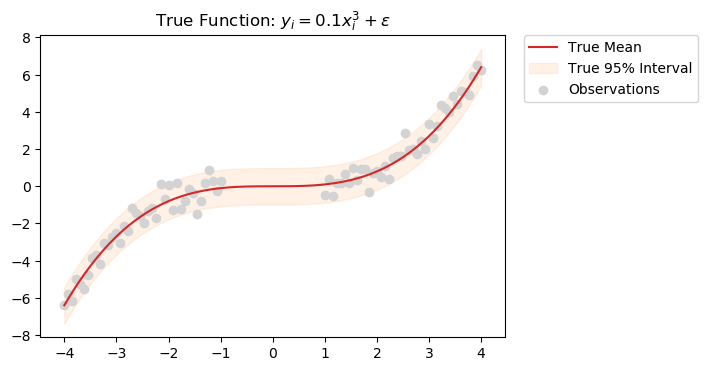

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x**3, scale=0.5)
func.latex = r'$y_i = 0.1x_i^3 + \varepsilon$'

data_points = [
    { 'n_points': 40, 'xlim': [-4, -1] },
    { 'n_points': 40, 'xlim': [1, 4] },
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f'True Function: {func.latex}')

[Iteration    1] Sum of squared errors: 2908.909154
[Iteration 1000] Sum of squared errors: 16.967336
[Iteration 2000] Sum of squared errors: 15.072368
[Iteration 3000] Sum of squared errors: 14.335296
[Iteration 4000] Sum of squared errors: 13.830800
[Iteration 5000] Sum of squared errors: 13.525531


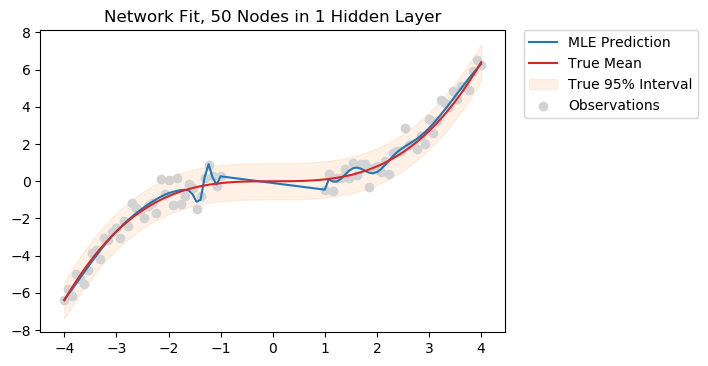

In [4]:
# Fit a neural network with a speficied number of nodes in a single hidden layer
width = 50
nn = SimpleNN(width=width, num_iters=5_000, step_size=0.01, checkpoint=1_000, seed=0)
nn.fit(df.x, df.y)

# Plot MLE predictions. Overfitting is usually expected.
y_pred = nn.predict(df.x)
plt.plot(df.x, y_pred, label='MLE Prediction')
plot_true_function(func, df, title=f'Network Fit, {width} Nodes in 1 Hidden Layer')

# Sampling from the posterior

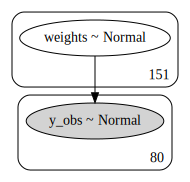

In [16]:
# Standard deviation of the prior. Should be appropriate for a specific network configuration.
sigma = 1.0
# Standard deviation of the likelihood, 0.5 is the true noise.
noise = 0.25

x_input = theano.shared(df[['x']].values)
y_output = theano.shared(df['y'].values)

# Build a hierarchical Bayesian neural network. Initialize with MLE.
model = build_model(x_input, y_output, sigma, noise, width, n_weights=nn.n_weights, init=nn.weights)

# Visualize the model
pm.model_to_graphviz(model)

In [17]:
# Sample from the posterior using the No-U-Turn sampler
trace = pm.sample(draws=1000, tune=1000, init="adapt_diag", target_accept=0.9,
                  cores=2, random_seed=[1, 2], model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weights]
Sampling 2 chains: 100%|██████████| 4000/4000 [07:56<00:00,  8.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


# Diagnostics of sampling

In [18]:
# Convert the trace to arviz format with the possibility to select specific weights for plotting
data = az.from_pymc3(trace=trace,
                     coords={'weight': range(nn.n_weights)}, 
                     dims={'weights': ['weight']})

In [19]:
# Print the Effective Sample Size and the Gelman-Rubin Test
tests = az.summary(data, round_to=2)[['ess_mean', 'r_hat']]
print(f'Minimum ESS: {tests.ess_mean.min():,.2f}')
print(f'Max Gelman-Rubin: {tests.r_hat.max():.2f}')
tests.T

Minimum ESS: 496.10
Max Gelman-Rubin: 1.01


,weights[0],weights[1],weights[2],weights[3],weights[4],weights[5],weights[6],weights[7],weights[8],weights[9],weights[10],weights[11],weights[12],weights[13],weights[14],weights[15],weights[16],weights[17],weights[18],weights[19],weights[20],weights[21],weights[22],weights[23],weights[24],weights[25],weights[26],weights[27],weights[28],weights[29],weights[30],weights[31],weights[32],weights[33],weights[34],weights[35],weights[36],weights[37],weights[38],weights[39],weights[40],weights[41],weights[42],weights[43],weights[44],weights[45],weights[46],weights[47],weights[48],weights[49],weights[50],weights[51],weights[52],weights[53],weights[54],weights[55],weights[56],weights[57],weights[58],weights[59],weights[60],weights[61],weights[62],weights[63],weights[64],weights[65],weights[66],weights[67],weights[68],weights[69],weights[70],weights[71],weights[72],weights[73],weights[74],weights[75],weights[76],weights[77],weights[78],weights[79],weights[80],weights[81],weights[82],weights[83],weights[84],weights[85],weights[86],weights[87],weights[88],weights[89],weights[90],weights[91],weights[92],weights[93],weights[94],weights[95],weights[96],weights[97],weights[98],weights[99],weights[100],weights[101],weights[102],weights[103],weights[104],weights[105],weights[106],weights[107],weights[108],weights[109],weights[110],weights[111],weights[112],weights[113],weights[114],weights[115],weights[116],weights[117],weights[118],weights[119],weights[120],weights[121],weights[122],weights[123],weights[124],weights[125],weights[126],weights[127],weights[128],weights[129],weights[130],weights[131],weights[132],weights[133],weights[134],weights[135],weights[136],weights[137],weights[138],weights[139],weights[140],weights[141],weights[142],weights[143],weights[144],weights[145],weights[146],weights[147],weights[148],weights[149],weights[150]
ess_mean,790.28,796.0,1148.79,691.71,718.77,850.21,658.44,883.06,644.17,534.57,900.56,665.06,851.66,758.69,496.1,826.04,892.86,728.63,760.96,808.06,992.11,924.01,548.86,731.22,830.99,670.25,744.19,1031.72,821.56,732.97,829.65,703.27,848.2,765.7,825.6,876.98,707.83,774.15,640.1,818.24,934.93,874.99,757.11,859.38,990.51,728.01,536.17,710.72,711.73,808.38,1341.61,1425.4,1042.81,872.32,1337.68,920.89,1321.72,1350.45,1211.03,1143.93,1333.73,954.04,1493.02,986.65,1186.42,1460.92,1082.29,1332.63,1479.65,1374.03,1294.18,1054.73,1413.92,1115.87,1263.09,959.09,1297.24,1161.71,1311.48,1372.72,1207.22,1686.84,1256.78,777.30,1222.36,1512.54,1200.90,1130.15,1142.08,1207.39,1368.12,1390.54,1292.09,1101.94,932.75,1324.37,1300.67,1151.1,1072.98,1285.57,1054.45,1582.92,995.8,1451.43,1233.05,1377.56,1310.56,1107.15,1325.87,1293.35,1407.93,1346.21,1263.89,1101.82,1472.2,1442.56,1088.78,1220.89,1327.91,1669.76,1341.87,1125.8,1463.4,1199.21,1238.82,930.07,1252.91,1509.91,1394.82,1074.99,1322.05,1575.37,1211.39,1153.93,1303.3,1384.95,1227.87,1150.98,1106.15,1176.58,1212.36,1039.65,1184.41,1310.51,1206.89,1281.2,1293.38,1684.0,1109.09,1451.24,2342.21
r_hat,1.00,1.0,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.00,1.00


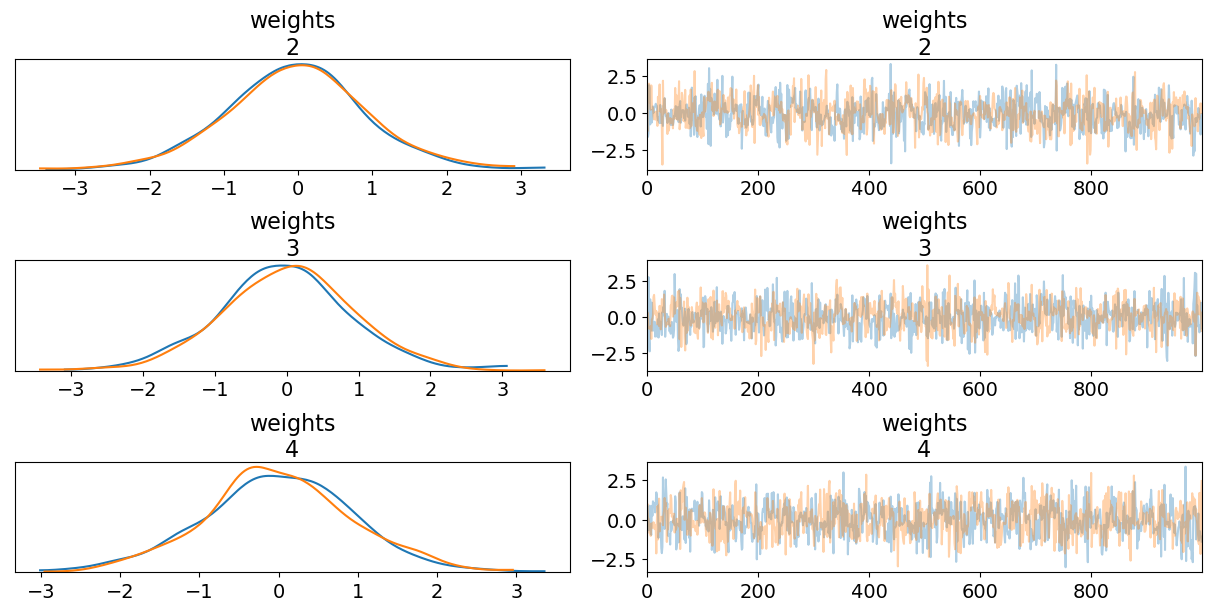

In [9]:
# Plot selected weights for illustration
az.plot_trace(data, coords={'weight': range(2, 5)});

In [10]:
# Optionally plot autocorrelation (the list may be long). 
# The effective sample size above is a good alternative.
# az.plot_autocorr(data, combined=True);

# Automatic differentiation variational inference

In [10]:
with model:
    mean_field = pm.fit(20_000, method='advi', obj_n_mc=10, obj_optimizer=pm.adagrad())
    trace_advi = mean_field.sample(10_000)

Average Loss = 208.3: 100%|██████████| 20000/20000 [00:50<00:00, 395.13it/s] 
Finished [100%]: Average Loss = 208.3


# Posterior predictive

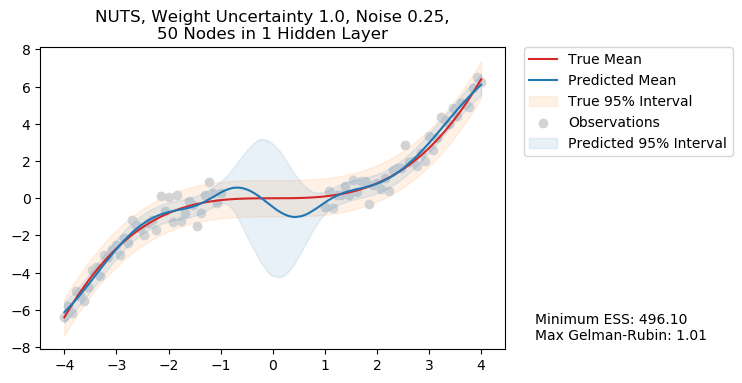

In [20]:
# Simulate data from the posterior predictive using the NUTS posterior
x_test = np.linspace(df.x.min(), df.x.max(), num=1000)
posterior_predictive = simulate_posterior_predictive(trace, nn, x_test, n_samples=10_000)

# Plot the results: truth vs prediction
plot_posterior_predictive(x_test, posterior_predictive, func=func, df=df,
                          title=f'NUTS, Weight Uncertainty {sigma}, Noise {noise},\n'
                                f'{width} Nodes in 1 Hidden Layer')
diagnostics = (f'Minimum ESS: {tests.ess_mean.min():,.2f}\n'
               f'Max Gelman-Rubin: {tests.r_hat.max():.2f}')
plt.gcf().text(0.95, 0.15, diagnostics)
plt.savefig(f"NUTS_hidden_1_width_{width}_sigma_{sigma}_noise_{noise}.png", dpi=plt.gcf().dpi, bbox_inches="tight")

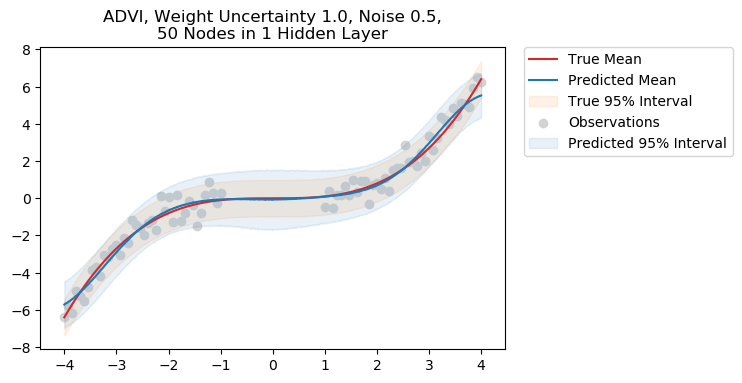

In [14]:
# Simulate data from the posterior predictive using ADVI approximation of the posterior
posterior_predictive = simulate_posterior_predictive(trace_advi, nn, x_test, n_samples=10_000)

# Plot the results: truth vs prediction
plot_posterior_predictive(x_test, posterior_predictive, func=func, df=df,
                          title=f'ADVI, Weight Uncertainty {sigma}, Noise {noise},\n'
                                f'{width} Nodes in 1 Hidden Layer')

---

# True function: $y_i = 0.5 x_i + 3 \sin(x_i) + \varepsilon_i$ (heteroscedastic)

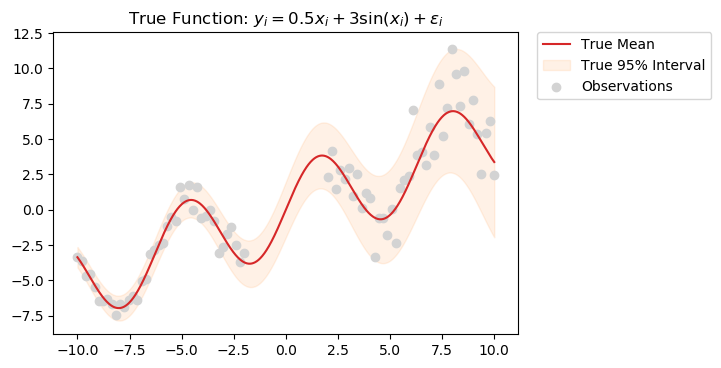

In [15]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.5*x + 3*np.sin(x), scale=np.exp(x/10))
func.latex = r'$y_i = 0.5x_i + 3 \sin(x_i) + \varepsilon_i$'

data_points = [
    { 'n_points': 40, 'xlim': [-10, -2] },
    { 'n_points': 40, 'xlim': [2, 10] },
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f'True Function: {func.latex}')